# Análisis de Vulnerabilidad Sanitaria en Cataluña

Este notebook presenta un análisis detallado sobre la distribución de recursos sanitarios (hospitales y desfibriladores) en relación con el nivel socioeconómico de las comarcas de Cataluña. 

El objetivo es identificar zonas críticas donde la alta vulnerabilidad social coincide con una baja cobertura de recursos sanitarios.

### 1. Carga de librerías y obtención de datos
Conectamos con la API de Transparencia de Cataluña para obtener los datos en tiempo real de desfibriladores y hospitales, y cargamos los datos socioeconómicos locales.

In [ ]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns

# Conexión a la API de Transparencia Catalunya
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Descarga de datasets: Desfibriladores (DEA) y Hospitales
desfibriladors = client.get("wpud-ukyg")
hospitales = client.get("8gmd-gz7i")

# Carga de datos socioeconómicos locales
df_socioeconomic = pd.read_csv("socio_eco.csv")

### 2. Procesamiento de indicadores socioeconómicos
Limpiamos los datos del censo y construimos un **Índice de Pobreza Socioeconómica** personalizado. Este índice combina variables clave como nivel de estudios, renta per cápita y tasa de desempleo para puntuar la vulnerabilidad de cada municipio.

In [ ]:
# Limpieza del dataset del censo
df_cens = pd.read_csv("cens.csv", sep=';')
df_cens.drop(columns=['estat', 'any', 'concepte', 'geo'], inplace=True)

# Filtrado de filas no relevantes (totales o agrupaciones)
df_cens = df_cens[~df_cens['edat'].str.contains('any', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('homes', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('dones', na=False)]
df_cens = df_cens[~df_cens['municipi'].str.contains('anys', na=False)]
df_cens.drop(columns=['edat', 'sexe'], inplace=True)

# Procesamiento de datos socioeconómicos
df_socioeconomic = pd.read_csv("socio_eco.csv")
df_socioeconomic = df_socioeconomic[['any', 'municipi', 'concepte', 'valor']]
df_socioeconomic['valor'] = pd.to_numeric(df_socioeconomic['valor'], errors='coerce')

# Pivotar tabla para tener conceptos como columnas
df_socioeconomic = df_socioeconomic.pivot_table(
    index=['any', 'municipi'],
    columns='concepte',
    values='valor',
    aggfunc='first'
).reset_index()

# Imputación de valores nulos con la media
for column in df_socioeconomic.columns:
    if df_socioeconomic[column].dtype in ['float64', 'int64']:
        mean_value = df_socioeconomic[column].mean()
        df_socioeconomic[column].fillna(mean_value, inplace=True)

# Crear variable de desempleo
df_socioeconomic['població desocupada(%)'] = 100 - df_socioeconomic['població ocupada (%)']
df_socioeconomic.drop(columns=['població ocupada (%)'], inplace=True)

# Normalización Min-Max de las columnas numéricas
numeric_columns = df_socioeconomic.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    min_value = df_socioeconomic[column].min()
    max_value = df_socioeconomic[column].max()
    df_socioeconomic[column] = (df_socioeconomic[column] - min_value) / (max_value - min_value)

df_socioeconomic.drop(columns=['any', 'estrangers de països de renda baixa o mitjana (%)'], inplace=True)

# Cálculo del Índice de Pobreza Socioeconómica (Ponderación manual)
# Mayor valor = Mayor vulnerabilidad
df_socioeconomic['puntuació pobreza socioeconòmica'] = (
    df_socioeconomic['població amb estudis baixos (%)'] * (1/3) +
    df_socioeconomic['població jove sense estudis postobligatoris (%)'] * (1/6) -
    df_socioeconomic['renda mitjana per persona (€)'] * (1/3) +
    df_socioeconomic['treballadors de baixa qualificació (%)'] * (1/12) +
    df_socioeconomic['població desocupada(%)'] * (1/12)
)

C:\Users\German\AppData\Local\Temp\ipykernel_1936\1381535994.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens=pd.read_csv("cens.csv", sep=';')  # Saltar líneas problemáticas
C:\Users\German\AppData\Local\Temp\ipykernel_1936\1381535994.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_socioeconomic[column].fillna(mean_value, inplace=True)


### 3. Validación del índice mediante PCA
Para asegurar la robustez de nuestro índice manual, realizamos un **Análisis de Componentes Principales (PCA)**. Comparamos nuestro índice calculado con el primer componente principal (PC1) para verificar si capturamos correctamente la varianza de los datos.

Pesos del PCA:
població amb estudis baixos (%)                    0.476087
població jove sense estudis postobligatoris (%)    0.526400
treballadors de baixa qualificació (%)             0.306693
població desocupada(%)                             0.365872
renta_inv                                          0.517998
dtype: float64

Varianza explicada por la primera componente: 0.547710004148582


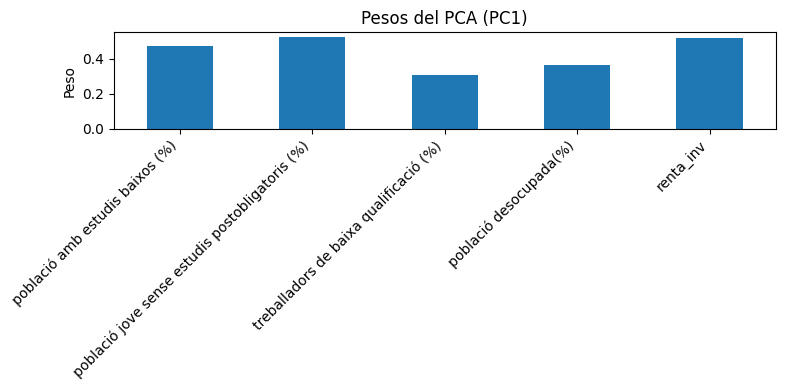

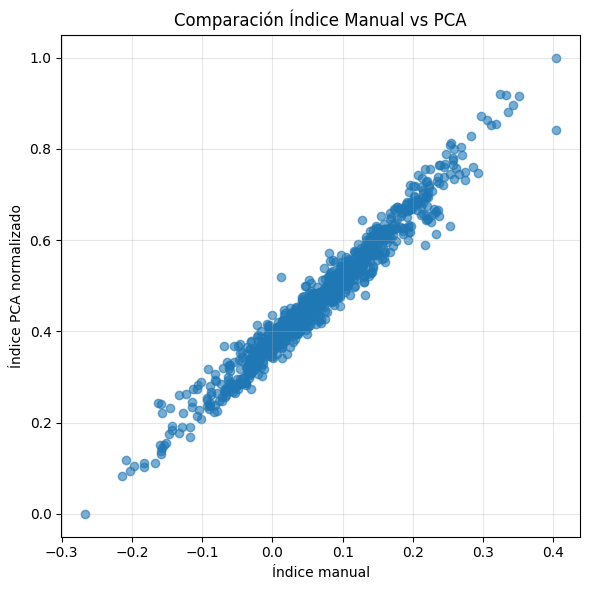

Correlación manual vs PCA = 0.9803282244785025


In [ ]:
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Variables seleccionadas para el índice
vars_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renda mitjana per persona (€)'
]

# Invertimos la renta para que la dirección sea consistente (Mayor valor = Mayor pobreza)
df_socioeconomic['renta_inv'] = 1 - df_socioeconomic['renda mitjana per persona (€)']

vars_for_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renta_inv'
]

X = df_socioeconomic[vars_for_pca].values

# Aplicar PCA (1 componente)
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X)

df_socioeconomic['indice_pca_bruto'] = pc1[:, 0]

# Normalizar el índice PCA a [0,1]
idx = df_socioeconomic['indice_pca_bruto']
df_socioeconomic['indice_pca_norm'] = (idx - idx.min()) / (idx.max() - idx.min())

# Resultados del PCA
pesos_pca = pd.Series(pca.components_[0], index=vars_for_pca)
print("Pesos del PCA:")
print(pesos_pca)
print("\nVarianza explicada por la primera componente:", pca.explained_variance_ratio_[0])

# Visualización de pesos
plt.figure(figsize=(8,4))
pesos_pca.plot(kind='bar')
plt.title("Contribución de variables al PCA (PC1)")
plt.ylabel("Peso")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Comparación: Índice Manual vs PCA
plt.figure(figsize=(6,6))
plt.scatter(
    df_socioeconomic['puntuació pobreza socioeconòmica'], 
    df_socioeconomic['indice_pca_norm'],
    alpha=0.6
)
plt.xlabel("Índice Manual")
plt.ylabel("Índice PCA Normalizado")
plt.title("Correlación: Índice Manual vs PCA")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr = df_socioeconomic['puntuació pobreza socioeconòmica'].corr(df_socioeconomic['indice_pca_norm'])
print("Correlación manual vs PCA =", corr)

### 4. Agregación de recursos sanitarios
Procesamos los datos brutos de la API para contar cuántos **desfibriladores** y **hospitales** existen en cada municipio y comarca. Esto nos permitirá calcular la densidad de recursos.

In [ ]:
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 

# Selección de columnas relevantes
df_desfibriladors = df_desfibriladors[['comarca', 'municipi']]
df_hospitales = df_hospitales[['poblacio', 'comarca']]

# Conteo de recursos por municipio y comarca
des_count_municipi = df_desfibriladors['municipi'].value_counts().reset_index()
des_count_comarca = df_desfibriladors['comarca'].value_counts().reset_index() 

hospi_count_municipi = df_hospitales['poblacio'].value_counts().reset_index()
hospi_count_comarca = df_hospitales['comarca'].value_counts().reset_index()

# Unificación de datos por municipio
recursos_municipi = pd.merge(des_count_municipi, hospi_count_municipi, left_on='municipi', right_on='poblacio', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_municipi['recursos_sanitaris_totals'] = recursos_municipi['count_desfibriladors'] + recursos_municipi['count_hospitals']

# Unificación de datos por comarca
recursos_comarca = pd.merge(des_count_comarca, hospi_count_comarca, left_on='comarca', right_on='comarca', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_comarca['recursos_sanitaris_totals'] = recursos_comarca['count_desfibriladors'] + recursos_comarca['count_hospitals']

### 5. Mapa de densidad de recursos sanitarios
Cruzamos los datos de recursos con la población de cada comarca para obtener el ratio de **Recursos por cada 1000 habitantes**. Visualizamos esta distribución en un mapa, aplicando un filtrado de outliers para mejorar la visualización.

Percentil 96% de recursos per 1000 hab: 1.39
Comarques amb valors > p96 (capeades): Alt Urgell, Alta Ribagorça


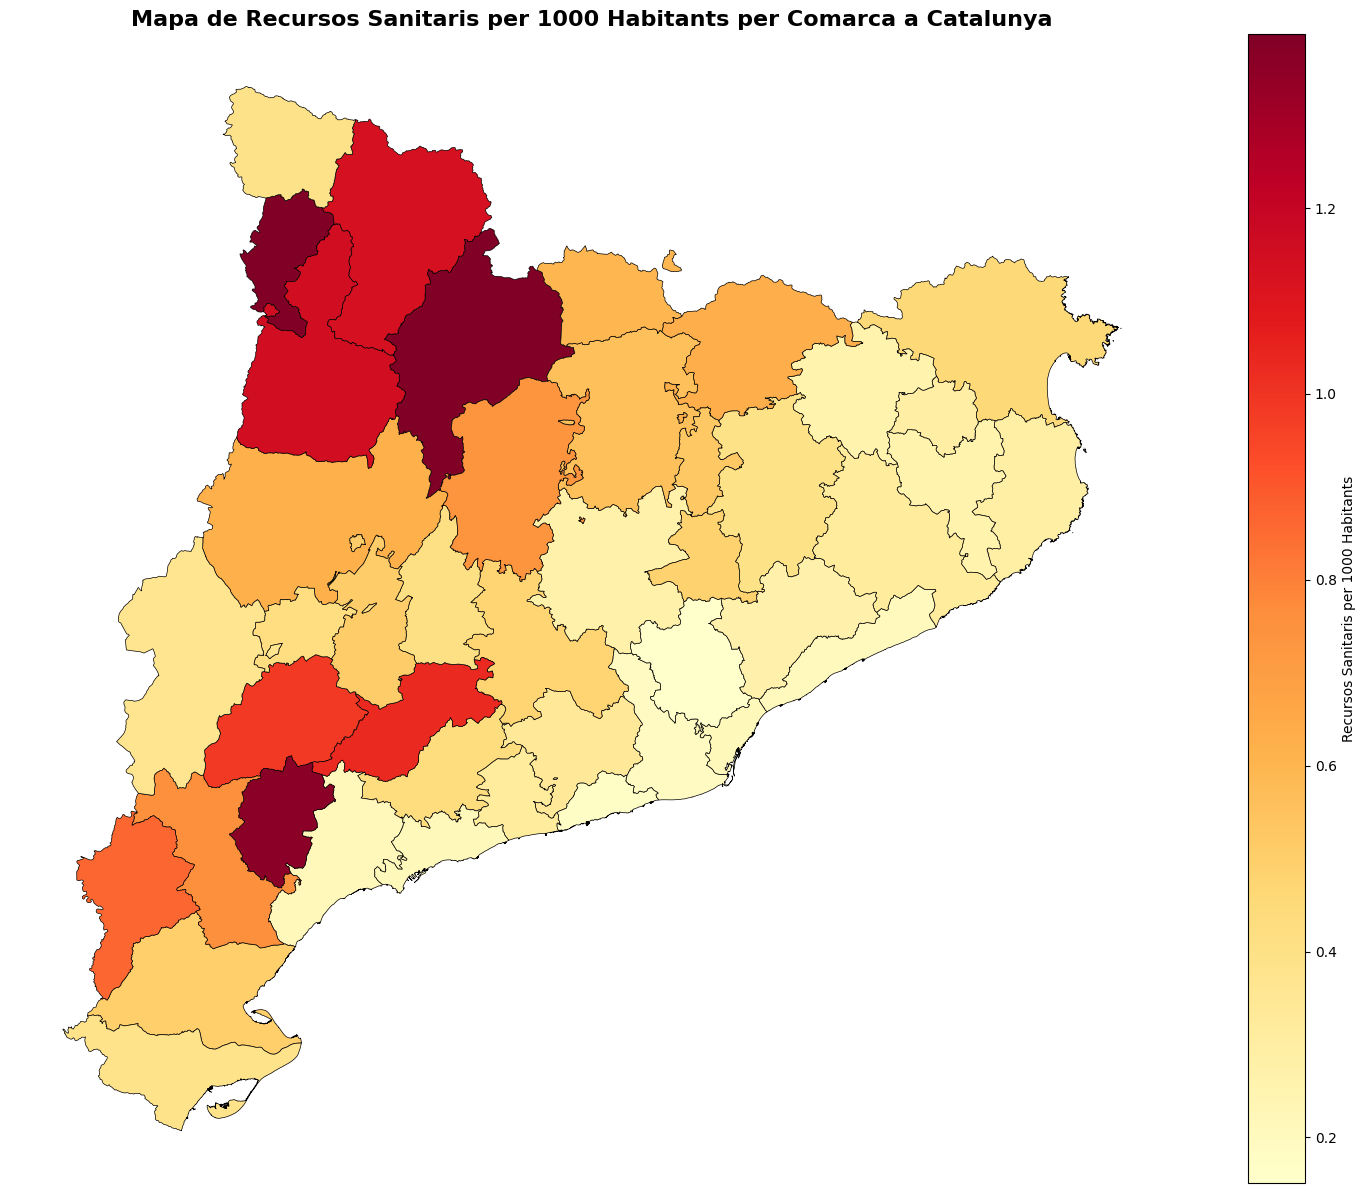

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis_geo = gpd.read_file(data_dir + "muni.json")
comarcas = gpd.read_file(data_dir + "comarcas.json")

# Asignar comarca a cada municipio del censo
df_cens_comarca = df_cens.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                 left_on='municipi', 
                                 right_on='NOMMUNI', 
                                 how='left')

# Calcular población total por comarca
poblacio_per_comarca = df_cens_comarca.groupby('NOMCOMAR')['valor'].sum().reset_index()
poblacio_per_comarca.columns = ['comarca', 'poblacio']

# Calcular ratio de recursos
recursos_comarca_poblacio = recursos_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
recursos_comarca_poblacio['recursos_per_1000_hab'] = (recursos_comarca_poblacio['recursos_sanitaris_totals'] / recursos_comarca_poblacio['poblacio']) * 1000

# Tratamiento de outliers (Capeado al percentil 96)
percentil_96 = recursos_comarca_poblacio['recursos_per_1000_hab'].quantile(0.96)
print(f"Límite superior (p96) para visualización: {percentil_96:.2f}")

recursos_comarca_poblacio['recursos_per_1000_hab'] = recursos_comarca_poblacio['recursos_per_1000_hab'].clip(upper=percentil_96)

# Preparación del GeoDataFrame
comarcas_recursos = comarcas.merge(recursos_comarca_poblacio, left_on='NOMCOMAR', right_on='comarca', how='left')
comarcas_recursos['recursos_per_1000_hab'] = comarcas_recursos['recursos_per_1000_hab'].fillna(0)

# Visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
comarcas_recursos.plot(column='recursos_per_1000_hab', 
                        ax=ax, 
                        legend=True,
                        cmap='YlOrRd',
                        edgecolor='black',
                        linewidth=0.5,
                        legend_kwds={'label': "Recursos Sanitaris per 1000 Habitants",
                                     'orientation': "vertical"})

ax.set_title('Distribución de Recursos Sanitarios por 1000 Habitants', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 6. Mapa de vulnerabilidad socioeconómica
Visualizamos el **Índice de Pobreza Socioeconómica** agregado por comarca. Las zonas en rojo indican mayor vulnerabilidad (peores indicadores socioeconómicos), mientras que las verdes indican mayor bienestar.

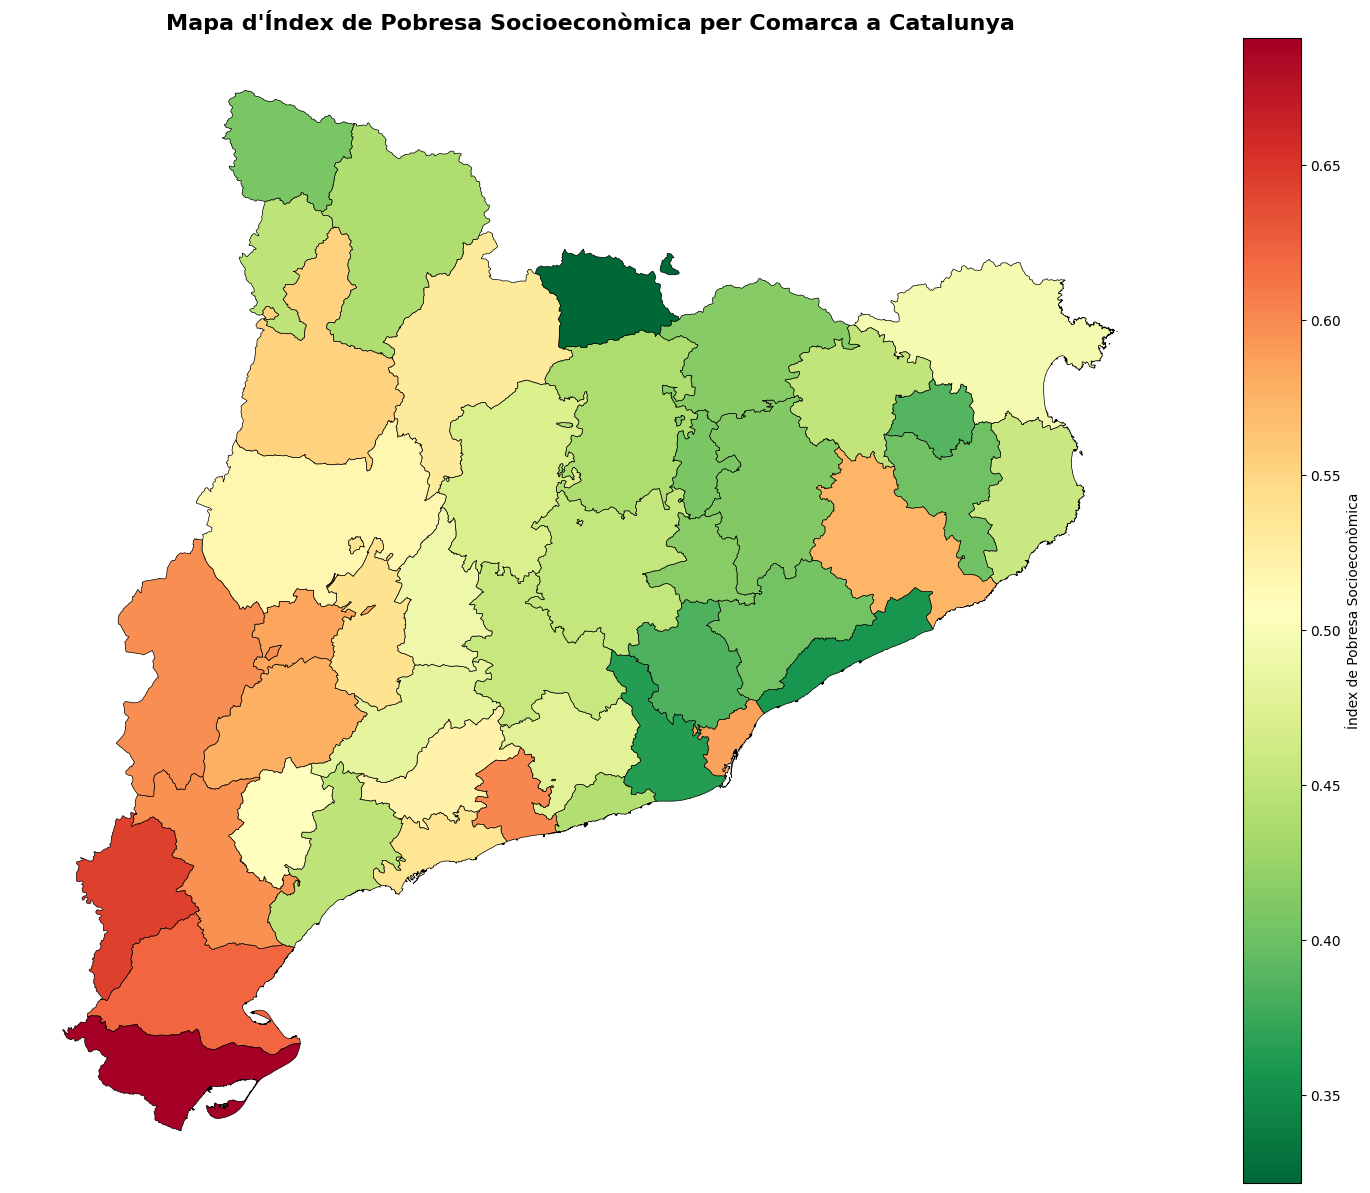

In [ ]:
# Asignar comarca a datos socioeconómicos
df_socioeconomic_comarca = df_socioeconomic.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                                    left_on='municipi', 
                                                    right_on='NOMMUNI', 
                                                    how='left')

# Promedio del índice de pobreza por comarca
pobreza_per_comarca = df_socioeconomic_comarca.groupby('NOMCOMAR')['indice_pca_norm'].mean().reset_index()
pobreza_per_comarca.columns = ['comarca', 'puntuacio_pobreza']

# Preparación del GeoDataFrame
comarcas_pobreza = comarcas.merge(pobreza_per_comarca, left_on='NOMCOMAR', right_on='comarca', how='left')
comarcas_pobreza['puntuacio_pobreza'] = comarcas_pobreza['puntuacio_pobreza'].fillna(0)

# Visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
comarcas_pobreza.plot(column='puntuacio_pobreza', 
                       ax=ax, 
                       legend=True,
                       cmap='RdYlGn_r',  # Rojo = más pobreza
                       edgecolor='black',
                       linewidth=0.5,
                       legend_kwds={'label': "Índex de Pobresa Socioeconòmica",
                                    'orientation': "vertical"})

ax.set_title('Índice de Pobreza Socioeconómica por Comarca', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 7. Análisis Bivariante: Recursos Totales vs. Pobreza
Cruzamos ambas dimensiones para identificar patrones. Utilizamos un **mapa bivariante** y un análisis de **clustering (K-Means)** para clasificar las comarcas en tres grupos:
1. **Critical:** Alta pobreza y bajos recursos (Prioridad alta).
2. **High resources:** Alta pobreza pero compensada con recursos.
3. **Low risk:** Baja pobreza.

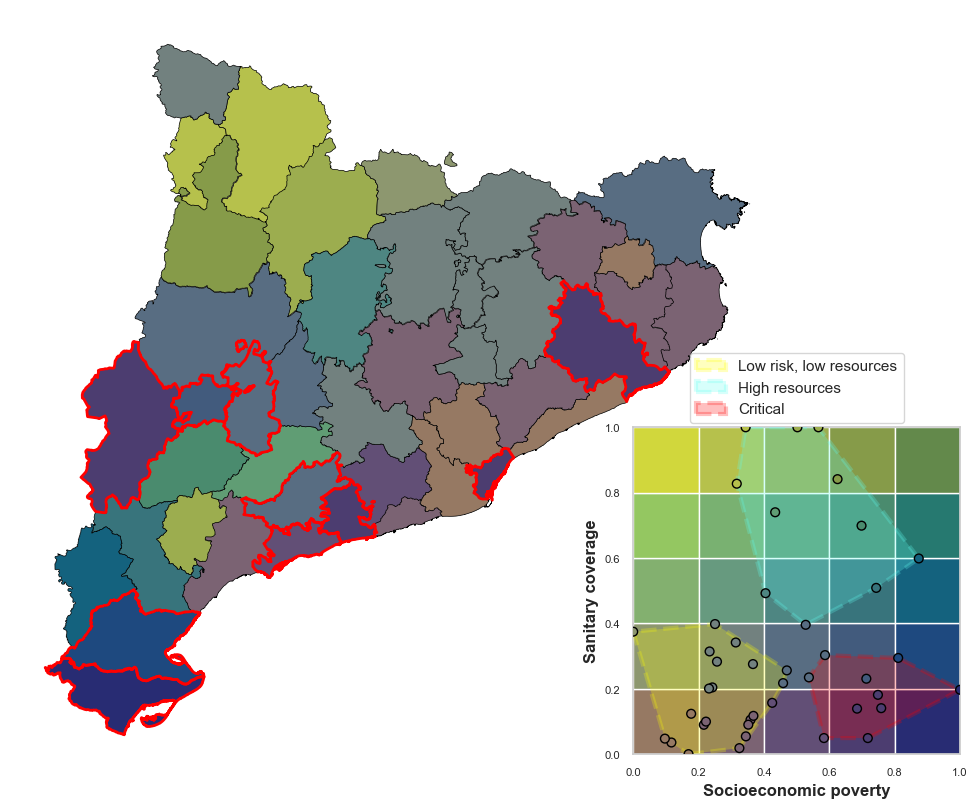

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# --- Preparación de Datos ---
datos_combinados = recursos_comarca_poblacio.merge(pobreza_per_comarca, on='comarca', how='inner')

# Filtrado de outliers para el clustering (evitar distorsión)
percentil_95 = datos_combinados['recursos_per_1000_hab'].quantile(0.95)
mask_no_outliers = datos_combinados['recursos_per_1000_hab'] <= percentil_95
datos_combinados['recursos_per_1000_hab'] = datos_combinados['recursos_per_1000_hab'].clip(upper=percentil_95)

# Normalización [0, 1]
min_recursos = datos_combinados['recursos_per_1000_hab'].min()
max_recursos = datos_combinados['recursos_per_1000_hab'].max()
datos_combinados['recursos_norm'] = (datos_combinados['recursos_per_1000_hab'] - min_recursos) / (max_recursos - min_recursos)

min_pobreza = datos_combinados['puntuacio_pobreza'].min()
max_pobreza = datos_combinados['puntuacio_pobreza'].max()
datos_combinados['pobreza_norm'] = (datos_combinados['puntuacio_pobreza'] - min_pobreza) / (max_pobreza - min_pobreza)

# --- Clustering (K-Means) ---
X = datos_combinados[['pobreza_norm', 'recursos_norm']].values
X_fit = X[mask_no_outliers] 

kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
kmeans.fit(X_fit)
datos_combinados['Cluster'] = kmeans.predict(X)

# Etiquetado automático de clusters
centroids = datos_combinados.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices = centroids.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels = {}
cluster_labels[sorted_indices[2]] = "Low risk, low resources" # Menor pobreza

# Diferenciar los dos grupos de mayor pobreza por sus recursos
idx_a, idx_b = sorted_indices[0], sorted_indices[1]
if centroids.loc[idx_a, 'recursos_norm'] < centroids.loc[idx_b, 'recursos_norm']:
    cluster_labels[idx_a] = "Critical"
    cluster_labels[idx_b] = "High resources"
else:
    cluster_labels[idx_a] = "High resources"
    cluster_labels[idx_b] = "Critical"

datos_combinados['label'] = datos_combinados['Cluster'].map(cluster_labels)

# --- Configuración de Colores Bivariantes ---
n_bins = 5
datos_combinados['pobreza_bin'] = np.floor(datos_combinados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_combinados['recursos_bin'] = np.floor(datos_combinados['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

colors_pobreza = plt.cm.cividis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)
colors_recursos = plt.cm.viridis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    return [(col_pob[0] + col_rec[0])/2, (col_pob[1] + col_rec[1])/2, (col_pob[2] + col_rec[2])/2]

datos_combinados['color_rgb'] = datos_combinados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_combinado = comarcas.merge(datos_combinados, left_on='NOMCOMAR', right_on='comarca', how='left')

# --- Visualización ---
fig, ax_map = plt.subplots(1, 1, figsize=(10, 10))

# Mapa principal
comarcas_con_color = comarcas_combinado[comarcas_combinado['color_rgb'].notna()].copy()
comarcas_sin_color = comarcas_combinado[comarcas_combinado['color_rgb'].isna()]

if len(comarcas_sin_color) > 0:
    comarcas_sin_color.plot(ax=ax_map, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color.iterrows():
    comarcas_con_color.loc[[idx]].plot(ax=ax_map, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Resaltar zonas críticas
comarcas_criticas = comarcas_combinado[comarcas_combinado['label'] == 'Critical']
if not comarcas_criticas.empty:
    comarcas_criticas.plot(ax=ax_map, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map.axis('off')

# Leyenda Bivariante (Scatter Inset)
ax_scatter = ax_map.inset_axes([0.80, 0.02, 0.43, 0.43])

# Fondo de cuadrícula de colores
for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter.add_patch(rect)

# Convex Hulls para los clusters
cluster_colors = {'Critical': '#FF0000', 'High resources': "#60FFF2", 'Low risk, low resources': '#FFFF00'}
unique_clusters = np.sort(datos_combinados['Cluster'].unique())

for cluster in unique_clusters:
    cluster_data = datos_combinados[datos_combinados['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter.add_patch(poly)

# Puntos de las comarcas
ax_scatter.scatter(
    datos_combinados['pobreza_norm'],
    datos_combinados['recursos_norm'],
    c=datos_combinados['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter.set_xlim(0, 1)
ax_scatter.set_ylim(0, 1)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlabel('Pobreza Socioeconómica', fontsize=12, fontweight='bold')
ax_scatter.set_ylabel('Cobertura Sanitaria', fontsize=12, fontweight='bold')
ax_scatter.tick_params(labelsize=8)
ax_scatter.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=11, ncol=1)

plt.show()

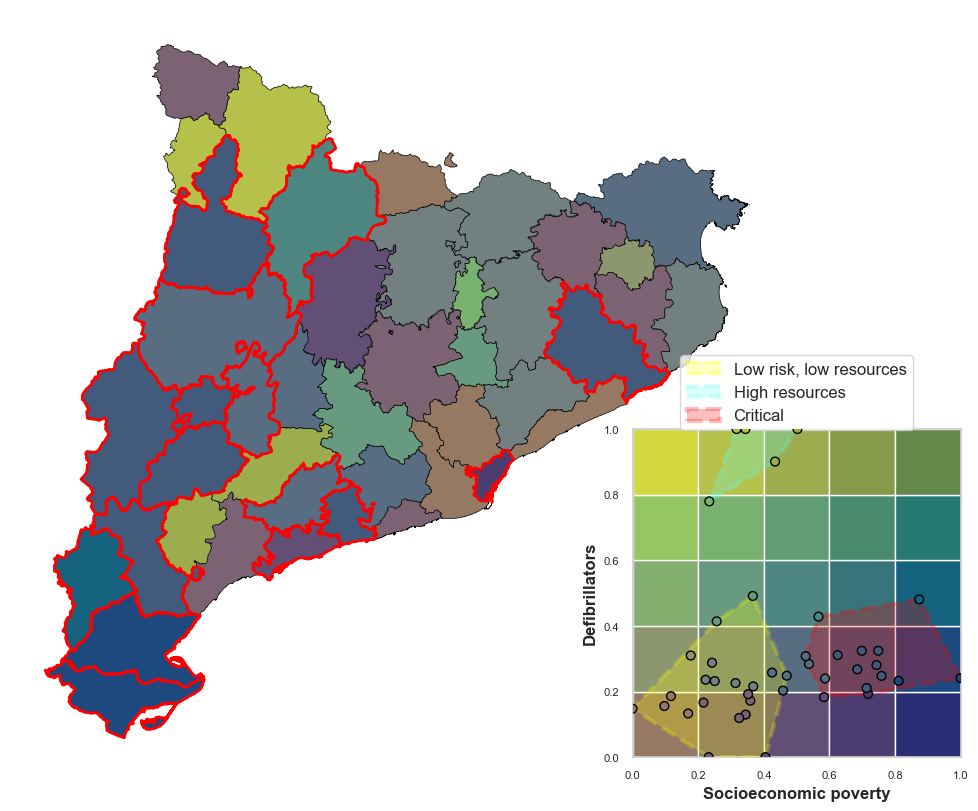

In [ ]:
# --- Preparación de Datos (Desfibriladores) ---
desfib_per_comarca = recursos_comarca[['comarca', 'count_desfibriladors']].copy()
desfib_per_comarca = desfib_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
desfib_per_comarca['desfib_per_1000_hab'] = (desfib_per_comarca['count_desfibriladors'] / desfib_per_comarca['poblacio']) * 1000

datos_desfib = desfib_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Clip y Normalización
percentil_95_d = datos_desfib['desfib_per_1000_hab'].quantile(0.95)
datos_desfib['desfib_per_1000_hab'] = datos_desfib['desfib_per_1000_hab'].clip(upper=percentil_95_d)

min_recursos_d = datos_desfib['desfib_per_1000_hab'].min()
max_recursos_d = datos_desfib['desfib_per_1000_hab'].max()
datos_desfib['recursos_norm'] = (datos_desfib['desfib_per_1000_hab'] - min_recursos_d) / (max_recursos_d - min_recursos_d)

min_pobreza_d = datos_desfib['puntuacio_pobreza'].min()
max_pobreza_d = datos_desfib['puntuacio_pobreza'].max()
datos_desfib['pobreza_norm'] = (datos_desfib['puntuacio_pobreza'] - min_pobreza_d) / (max_pobreza_d - min_pobreza_d)

# --- Clustering ---
X_d = datos_desfib[['pobreza_norm', 'recursos_norm']].values
kmeans_d = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_d.fit(X_d)
datos_desfib['Cluster'] = kmeans_d.predict(X_d)

# Etiquetas
centroids_d = datos_desfib.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_d = centroids_d.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_d = {}
cluster_labels_d[sorted_indices_d[2]] = "Low risk, low resources"

idx_a, idx_b = sorted_indices_d[0], sorted_indices_d[1]
if centroids_d.loc[idx_a, 'recursos_norm'] < centroids_d.loc[idx_b, 'recursos_norm']:
    cluster_labels_d[idx_a] = "Critical"
    cluster_labels_d[idx_b] = "High resources"
else:
    cluster_labels_d[idx_a] = "High resources"
    cluster_labels_d[idx_b] = "Critical"

datos_desfib['label'] = datos_desfib['Cluster'].map(cluster_labels_d)

# --- Visualización ---
n_bins = 5
datos_desfib['pobreza_bin'] = np.floor(datos_desfib['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_desfib['recursos_bin'] = np.floor(datos_desfib['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_desfib['color_rgb'] = datos_desfib.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_desfib = comarcas.merge(datos_desfib, left_on='NOMCOMAR', right_on='comarca', how='left')

fig, ax_map_d = plt.subplots(1, 1, figsize=(10, 10))

# Mapa
comarcas_con_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].notna()].copy()
comarcas_sin_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].isna()]

if len(comarcas_sin_color_d) > 0:
    comarcas_sin_color_d.plot(ax=ax_map_d, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_d.iterrows():
    comarcas_con_color_d.loc[[idx]].plot(ax=ax_map_d, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Resaltar críticas
comarcas_criticas_d = comarcas_desfib[comarcas_desfib['label'] == 'Critical']
if not comarcas_criticas_d.empty:
    comarcas_criticas_d.plot(ax=ax_map_d, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_d.axis('off')

# Inset Scatter
ax_scatter_d = ax_map_d.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_d.add_patch(rect)

unique_clusters_d = np.sort(datos_desfib['Cluster'].unique())

for cluster in unique_clusters_d:
    cluster_data = datos_desfib[datos_desfib['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_d[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_d.add_patch(poly)

ax_scatter_d.scatter(
    datos_desfib['pobreza_norm'],
    datos_desfib['recursos_norm'],
    c=datos_desfib['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_d.set_xlim(0, 1)
ax_scatter_d.set_ylim(0, 1)
ax_scatter_d.set_aspect('equal')
ax_scatter_d.set_xlabel('Pobreza Socioeconómica', fontsize=12, fontweight='bold')
ax_scatter_d.set_ylabel('Desfibriladores', fontsize=12, fontweight='bold')
ax_scatter_d.tick_params(labelsize=8)
ax_scatter_d.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

### 8. Análisis Bivariante: Desfibriladores vs. Pobreza
Repetimos el análisis enfocándonos exclusivamente en la disponibilidad de **Desfibriladores (DEA)**. Esto nos permite ver si la distribución de estos dispositivos de emergencia sigue patrones diferentes a los recursos generales.

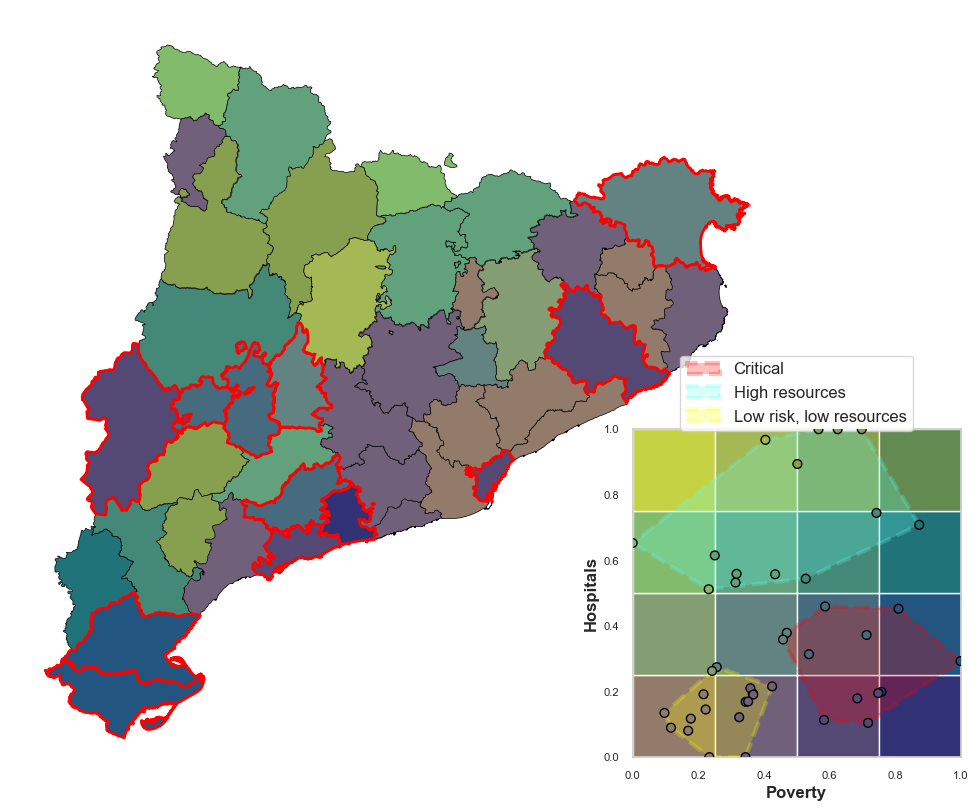

In [ ]:
# --- Preparación de Datos (Hospitales) ---
hospi_per_comarca = recursos_comarca[['comarca', 'count_hospitals']].copy()
hospi_per_comarca = hospi_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
hospi_per_comarca['hospi_per_1000_hab'] = (hospi_per_comarca['count_hospitals'] / hospi_per_comarca['poblacio']) * 1000

datos_hospi = hospi_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Clip y Normalización
percentil_95_h = datos_hospi['hospi_per_1000_hab'].quantile(0.95)
datos_hospi['hospi_per_1000_hab'] = datos_hospi['hospi_per_1000_hab'].clip(upper=percentil_95_h)

min_recursos_h = datos_hospi['hospi_per_1000_hab'].min()
max_recursos_h = datos_hospi['hospi_per_1000_hab'].max()
datos_hospi['recursos_norm'] = (datos_hospi['hospi_per_1000_hab'] - min_recursos_h) / (max_recursos_h - min_recursos_h)

min_pobreza_h = datos_hospi['puntuacio_pobreza'].min()
max_pobreza_h = datos_hospi['puntuacio_pobreza'].max()
datos_hospi['pobreza_norm'] = (datos_hospi['puntuacio_pobreza'] - min_pobreza_h) / (max_pobreza_h - min_pobreza_h)

# --- Clustering ---
X_h = datos_hospi[['pobreza_norm', 'recursos_norm']].values
kmeans_h = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_h.fit(X_h)
datos_hospi['Cluster'] = kmeans_h.predict(X_h)

# Etiquetas
centroids_h = datos_hospi.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_h = centroids_h.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_h = {}
cluster_labels_h[sorted_indices_h[2]] = "Low risk, low resources"

idx_a, idx_b = sorted_indices_h[0], sorted_indices_h[1]
if centroids_h.loc[idx_a, 'recursos_norm'] < centroids_h.loc[idx_b, 'recursos_norm']:
    cluster_labels_h[idx_a] = "Critical"
    cluster_labels_h[idx_b] = "High resources"
else:
    cluster_labels_h[idx_a] = "High resources"
    cluster_labels_h[idx_b] = "Critical"

datos_hospi['label'] = datos_hospi['Cluster'].map(cluster_labels_h)

# --- Visualización ---
n_bins = 4
datos_hospi['pobreza_bin'] = np.floor(datos_hospi['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_hospi['recursos_bin'] = np.floor(datos_hospi['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_hospi['color_rgb'] = datos_hospi.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_hospi = comarcas.merge(datos_hospi, left_on='NOMCOMAR', right_on='comarca', how='left')

fig, ax_map_h = plt.subplots(1, 1, figsize=(10, 10))

# Mapa
comarcas_con_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].notna()].copy()
comarcas_sin_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].isna()]

if len(comarcas_sin_color_h) > 0:
    comarcas_sin_color_h.plot(ax=ax_map_h, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_h.iterrows():
    comarcas_con_color_h.loc[[idx]].plot(ax=ax_map_h, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Resaltar críticas
comarcas_criticas_h = comarcas_hospi[comarcas_hospi['label'] == 'Critical']
if not comarcas_criticas_h.empty:
    comarcas_criticas_h.plot(ax=ax_map_h, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_h.axis('off')

# Inset Scatter
ax_scatter_h = ax_map_h.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_h.add_patch(rect)

unique_clusters_h = np.sort(datos_hospi['Cluster'].unique())

for cluster in unique_clusters_h:
    cluster_data = datos_hospi[datos_hospi['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_h[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_h.add_patch(poly)

ax_scatter_h.scatter(
    datos_hospi['pobreza_norm'],
    datos_hospi['recursos_norm'],
    c=datos_hospi['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_h.set_xlim(0, 1)
ax_scatter_h.set_ylim(0, 1)
ax_scatter_h.set_aspect('equal')
ax_scatter_h.set_xlabel('Pobreza', fontsize=12, fontweight='bold')
ax_scatter_h.set_ylabel('Hospitales', fontsize=12, fontweight='bold')
ax_scatter_h.tick_params(labelsize=8)
ax_scatter_h.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

### 9. Análisis Bivariante: Hospitales vs. Pobreza
Finalmente, analizamos la distribución de **Hospitales**. Dado que son infraestructuras críticas y menos numerosas, su distribución puede variar significativamente respecto a los DEAs.

✅ DataFrame detectado: 'datos_combinados'
   -> Normalizada columna de recursos desde 'recursos_per_1000_hab'

 1. RANKING DE VULNERABILIDAD SANITARIA
     comarca  Indice_Prioridad  recursos_per_1000_hab  puntuacio_pobreza
     Montsià          1.803062               0.385216           0.690868
  Barcelonès          1.668706               0.209459           0.586720
Baix Penedès          1.618205               0.318278           0.601858
      Segrià          1.567361               0.366777           0.598145
       Selva          1.545760               0.316506           0.574568
  Tarragonès          1.534389               0.209555           0.537172
   Baix Ebre          1.516352               0.500994           0.620980
Pla d'Urgell          1.482568               0.425423           0.585052
      Garraf          1.306485               0.172939           0.441685
    Alt Camp          1.302792               0.430221           0.520184

 2. CLUSTERING: TIPOLOGÍAS DE COMARCAS


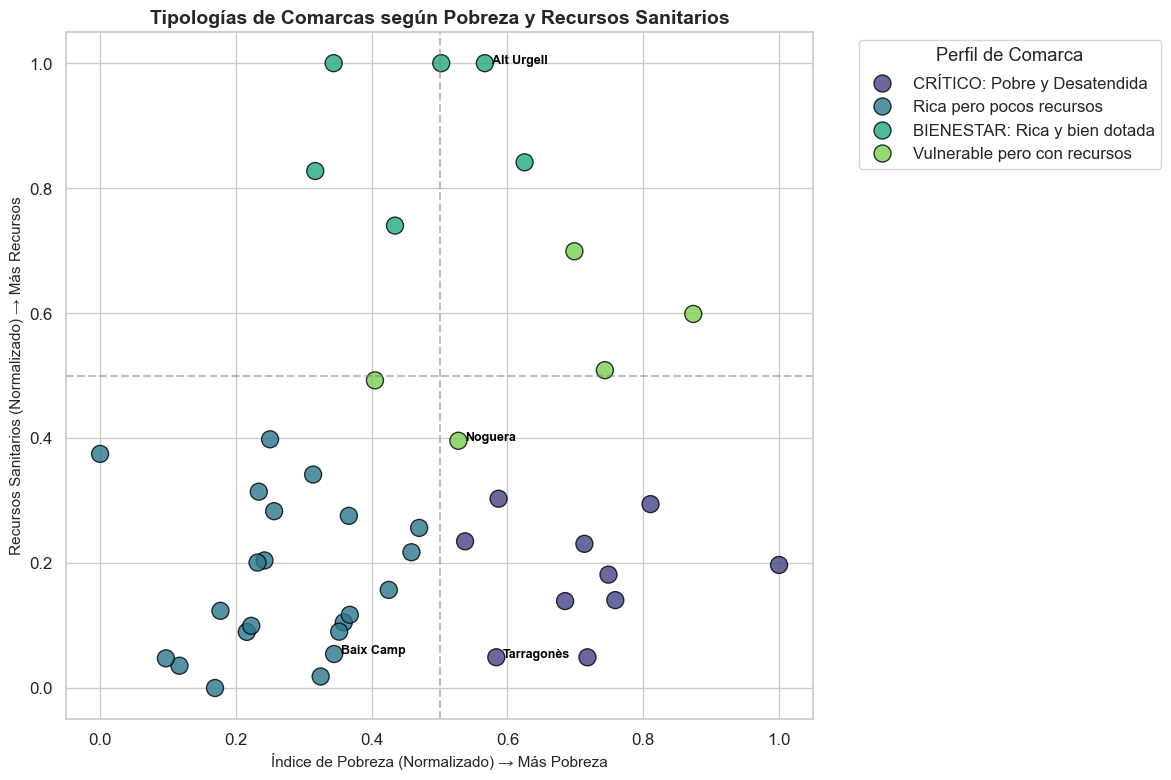


Resumen de los grupos encontrados:
Etiqueta_Cluster
Rica pero pocos recursos         22
CRÍTICO: Pobre y Desatendida     10
BIENESTAR: Rica y bien dotada     6
Vulnerable pero con recursos      5
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# --- Detección automática del DataFrame a analizar ---
if 'datos_combinados' in locals():
    df_analisis = datos_combinados.copy()
    print("✅ Analizando datos generales (Recursos Totales)")
elif 'datos_combinados_filtrados' in locals():
    df_analisis = datos_combinados_filtrados.copy()
    print("✅ Analizando datos filtrados")
else:
    raise ValueError("❌ No se encontraron datos procesados. Ejecuta las celdas anteriores.")

# Asegurar columnas normalizadas
if 'pobreza_norm' not in df_analisis.columns:
    col_origen = 'puntuacio_pobreza' if 'puntuacio_pobreza' in df_analisis.columns else 'indice_pca_norm'
    df_analisis['pobreza_norm'] = (df_analisis[col_origen] - df_analisis[col_origen].min()) / \
                                  (df_analisis[col_origen].max() - df_analisis[col_origen].min())

posibles_recursos = ['recursos_sin_norm', 'recursos_per_1000_hab', 'desfib_per_1000_hab']
col_recursos_orig = next((c for c in posibles_recursos if c in df_analisis.columns), None)

if col_recursos_orig:
    df_analisis['recursos_norm'] = (df_analisis[col_recursos_orig] - df_analisis[col_recursos_orig].min()) / \
                                   (df_analisis[col_recursos_orig].max() - df_analisis[col_recursos_orig].min())

# --- 1. Ranking de Prioridad ---
# Fórmula: Mayor Pobreza + Menores Recursos = Mayor Prioridad
df_analisis['Indice_Prioridad'] = df_analisis['pobreza_norm'] + (1 - df_analisis['recursos_norm'])

print(f"\n{'='*60}\n TOP 10 COMARCAS CON MAYOR VULNERABILIDAD SANITARIA\n{'='*60}")
top_prioridad = df_analisis.sort_values('Indice_Prioridad', ascending=False).head(10)
display_cols = ['comarca', 'Indice_Prioridad', col_recursos_orig, 'puntuacio_pobreza']
print(top_prioridad[display_cols].to_string(index=False))

# --- 2. Tipologías de Comarcas (Clustering Final) ---
X = df_analisis[['pobreza_norm', 'recursos_norm']].values
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_analisis['Cluster_Final'] = kmeans.fit_predict(X)

# Nombres descriptivos para los clusters
centroides = df_analisis.groupby('Cluster_Final')[['pobreza_norm', 'recursos_norm']].mean()
nombres_cluster = {}

for i, row in centroides.iterrows():
    pob, rec = row['pobreza_norm'], row['recursos_norm']
    if pob > 0.5 and rec < 0.5: etiqueta = "CRÍTICO: Pobre y Desatendida"
    elif pob > 0.5 and rec >= 0.5: etiqueta = "Vulnerable pero con recursos"
    elif pob <= 0.5 and rec < 0.5: etiqueta = "Rica pero pocos recursos"
    else: etiqueta = "BIENESTAR: Rica y bien dotada"
    nombres_cluster[i] = etiqueta

df_analisis['Etiqueta_Cluster'] = df_analisis['Cluster_Final'].map(nombres_cluster)

# Visualización Final
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_analisis, 
    x='pobreza_norm', 
    y='recursos_norm', 
    hue='Etiqueta_Cluster', 
    palette='viridis', 
    s=150,
    edgecolor='black',
    alpha=0.8
)

# Etiquetas para comarcas representativas
for cluster in df_analisis['Cluster_Final'].unique():
    sample = df_analisis[df_analisis['Cluster_Final'] == cluster].sample(1)
    plt.text(
        sample['pobreza_norm'].values[0]+0.01, 
        sample['recursos_norm'].values[0], 
        sample['comarca'].values[0], 
        fontsize=9, 
        weight='bold',
        color='black'
    )

plt.title('Tipologías de Comarcas: Mapa de Situación', fontsize=14, weight='bold')
plt.xlabel('Índice de Pobreza (Normalizado)', fontsize=11)
plt.ylabel('Recursos Sanitarios (Normalizado)', fontsize=11)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Perfil")
plt.tight_layout()
plt.show()

print("\nResumen de tipologías:")
print(df_analisis['Etiqueta_Cluster'].value_counts())

### 10. Conclusiones y Ranking de Vulnerabilidad
Para finalizar, generamos un **ranking de prioridad** combinando ambos factores. Identificamos las comarcas que requieren atención inmediata y clasificamos el territorio en 4 tipologías claras para facilitar la toma de decisiones.